<a href="https://colab.research.google.com/github/vaishalipp/ashrae-energy-predictor-3/blob/master/notebooks/Model_LGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1><center>ASHRAE - Great Energy Predictor III -  Modeling💡</center></h1>

# Libraries 📚

In [1]:
import numpy as np
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
import gc

In [3]:
#modeling
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import lightgbm as lgb
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Read data from interim files

In [4]:
is_colab = True

In [5]:
if is_colab:
  from google.colab import drive
  from pathlib import Path
  drive.mount("/content/drive", force_remount=True)
  #base = Path('/content/drive/My Drive/Capstone2/Ashrae')
  #import sys
  #sys.path.append(str(base))
  import os
  os.chdir('/content/drive/MyDrive/Capstone2/Ashrae')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly&response_type=code

Enter your authorization code:
4/1AY0e-g7KuYuwIBEqElttc-iSOtwNz3nnPR6_RWdVdTHsgf3C4dxGBNvJqPk
Mounted at /content/drive


In [6]:
if is_colab:
  !pip install pickle5
  import pickle5 as pickle
  train_df = pickle.load(open('data/train_df.pickle','rb'))
  test_df = pickle.load(open('data/test_df.pickle','rb'))
  building_metadata_df = pickle.load(open('data/building_metadata_df.pickle','rb'))
  weather_train_df = pickle.load(open('data/weather_train_df.pickle','rb'))
  weather_test_df = pickle.load(open('data/weather_test_df.pickle','rb'))
else:
  train_df = pd.read_pickle("../data/interim/post_featureEng/train_df.pickle")
  test_df = pd.read_pickle("../data/interim/post_featureEng/test_df.pickle")
  building_metadata_df = pd.read_pickle("../data/interim/post_featureEng/building_metadata_df.pickle")
  weather_train_df = pd.read_pickle("../data/interim/post_featureEng/weather_train_df.pickle")
  weather_test_df = pd.read_pickle("../data/interim/post_featureEng/weather_test_df.pickle")

     |████████████████████████████████| 133kB 12.7MB/s 
  Created wheel for pickle5: filename=pickle5-0.0.11-cp36-cp36m-linux_x86_64.whl size=218628 sha256=5cd88ba26128f97ea5ffc6553ee17da68028a6caebd6915d11c0a20d04da970d
  Stored in directory: /root/.cache/pip/wheels/a6/90/95/f889ca4aa8b0e0c7f21c8470b6f5d6032f0390a3a141a9a3bd
Successfully built pickle5


In [7]:
test_df.drop(columns='row_id',inplace=True)

In [8]:
train_df.reset_index(inplace=True)

### Reduce Memory

In [9]:
def reduce_mem_df(df):
    df_mem_before = df.memory_usage().sum() / 1024**2
    print("Memory usage of dataframe is {:.2f} MB".format(df_mem_before))
    
    for col in df.columns:
        if df[col].dtype == 'datetime64' or pd.api.types.is_categorical_dtype(df[col]):
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            elif str(col_type)[:5] == "float":
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype("category")

    df_mem_after = df.memory_usage().sum() / 1024**2
    print("Memory usage after optimization is: {:.2f} MB".format(df_mem_after))
    print("Decreased by {:.1f}%".format(100 * (df_mem_before - df_mem_after) / df_mem_before))
    
    return df

In [10]:
test_df = reduce_mem_df(test_df)

Memory usage of dataframe is 1988.30 MB
Memory usage after optimization is: 1550.87 MB
Decreased by 22.0%


In [11]:
#For LGBM Categorical data needs to be converted to int values
test_df['meter_type'] = test_df['meter_type'].astype(np.int8)
train_df['meter_type'] = train_df['meter_type'].astype(np.int8)

In [12]:
weather_train_df = reduce_mem_df(weather_train_df)

Memory usage of dataframe is 26.94 MB
Memory usage after optimization is: 13.94 MB
Decreased by 48.3%


In [13]:
weather_test_df = reduce_mem_df(weather_test_df)

Memory usage of dataframe is 53.73 MB
Memory usage after optimization is: 27.80 MB
Decreased by 48.3%


In [14]:
weather_train_df.drop(columns='time',inplace=True)
weather_test_df.drop(columns='time',inplace=True)

## Feature engineering

In [15]:
#Could have a used a label encoder here.
primary_use_list = building_metadata_df['primary_use'].unique()
primary_use_dict = {key: value for value, key in enumerate(primary_use_list)} 
print('primary_use_dict: ', primary_use_dict)
building_metadata_df['primary_use'] = building_metadata_df['primary_use'].map(primary_use_dict)
gc.collect()

primary_use_dict:  {'Education': 0, 'Lodging/residential': 1, 'Office': 2, 'Entertainment/public assembly': 3, 'Other': 4, 'Retail': 5, 'Parking': 6, 'Public services': 7, 'Warehouse/storage': 8, 'Food sales and service': 9, 'Religious worship': 10, 'Healthcare': 11, 'Utility': 12, 'Technology/science': 13, 'Manufacturing/industrial': 14, 'Services': 15}


0

In [16]:
building_metadata_df['primary_use'] = building_metadata_df['primary_use'].astype(np.int8)

In [17]:
weather_train_df['week'] = weather_train_df['week'].astype(np.int8)

In [18]:
category_cols = ["site_id","building_id","meter_type","primary_use", "hour","week","day_of_week","month","day_of_year"]

In [19]:
feature_cols = list(set(list(train_df.columns) + list(building_metadata_df.columns) + list(weather_train_df.columns))\
               - set(category_cols + list(['meter_reading_log1p','meter_reading','timestamp'])))

# Merge dfs

In [20]:
def merge_dfs(meter_df,weather_df):
    merged_meter_df = meter_df.merge(building_metadata_df, on=['building_id'],how='left')
    merged_meter_df = merged_meter_df.merge(weather_df, on=['site_id', 'timestamp'], how='left')
    return merged_meter_df

In [21]:
merged_meter_df = merge_dfs(train_df,weather_train_df)

In [22]:
def create_X_y(merged_meter_df,target_meter=None,drop_cols=[]):
    if target_meter is not None:
      merged_meter_df = merged_meter_df[merged_meter_df.meter_type==target_meter]
    X = merged_meter_df[list(set(feature_cols + category_cols) - set(drop_cols))]
    y = merged_meter_df['meter_reading_log1p'].values

    del merged_meter_df
    return X,y

# Create a holdout dataset 
*To be used as Test set to make predictions and compare models based on those.*

In [23]:
percent_80 = int(len(merged_meter_df)*0.8)
merged_train_df = merged_meter_df[:percent_80]
merged_test_df = merged_meter_df[percent_80:]
del merged_meter_df

### Define a df for comparing models

In [24]:
model_compare_df = pd.DataFrame(columns=['model_name','meter_type','mse_train','mse_test','R2-train','R2-test'])
#R2 - total variance explained by model

# Feature selection using sklearn

In [25]:
corr = merged_train_df.corr()
corr = pd.DataFrame(np.triu(corr.to_numpy(),1),index=corr.index,columns=corr.index).stack()

In [26]:
correlated_cols = list(set(['month','week','dew_temperature','site_id'] + \
                           list(merged_train_df.columns[merged_train_df.columns.str.match('(meter_build)|(.*lag)')])) \
                       - set(['meter_build_mean']))

# Linear model analysis

### Linear regression

In [27]:
def one_hot_encode(X):
  ohe = OneHotEncoder(drop='first')
  _df = pd.DataFrame(ohe.fit_transform(X[['primary_use']]).toarray())
  _df.columns = ohe.get_feature_names(['primary_use'])
  X = X.join(_df)
  del _df
  gc.collect()
  return X

In [28]:
#X = one_hot_encode(X) - Making the df size very large. 

In [29]:
def model_predict(model,model_name,X_train,y_train,X_test,y_test,is_LR=True):
  y_train_pred = model.predict(X_train)
  lr_mse_train = mean_squared_error(y_train,y_train_pred)
  lr_r2_train = r2_score(y_train,y_train_pred)

  
  y_test_pred = model.predict(X_test)
  lr_mse_test = mean_squared_error(y_test,y_test_pred)
  lr_r2_test = r2_score(y_test,y_test_pred)

  residuals_test = pd.DataFrame({"true":y_test, "residuals":y_test - y_test_pred})
  model_compare_df.loc[len(model_compare_df.index)] = [model_name,target_meter,lr_mse_train,lr_mse_test,lr_r2_train,lr_r2_test]

  if (is_LR==True):
    fig,axes = plt.subplots(1,3,figsize=(15,3))
    residuals_test.plot(x='true',y='residuals',kind='scatter',title='meter_'+ str(target_meter),ax=axes[0])
    coef = pd.Series(model['model'].coef_,X_train.columns).sort_values()
    coef.plot(kind='bar',title='model coefficients',ax=axes[1])
    sm.qqplot(residuals_test['residuals'],ax=axes[2])
  else:
    fig,axes = plt.subplots(1,1,figsize=(5,3))
    residuals_test.plot(x='true',y='residuals',kind='scatter',title='meter_'+ str(target_meter),ax=axes)
  #https://www.analyticsvidhya.com/blog/2013/12/residual-plots-regression-model/


CPU times: user 15 s, sys: 5.87 s, total: 20.9 s
Wall time: 11.7 s


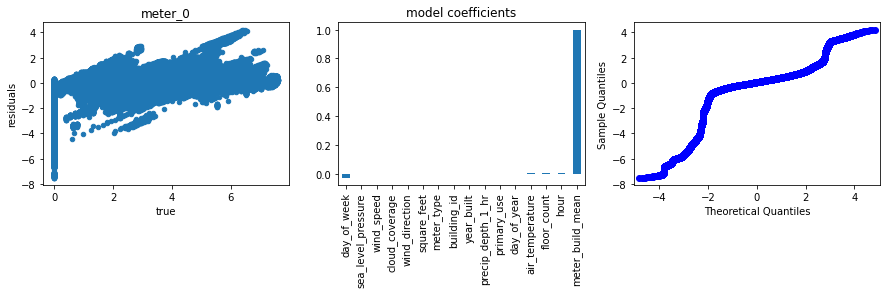

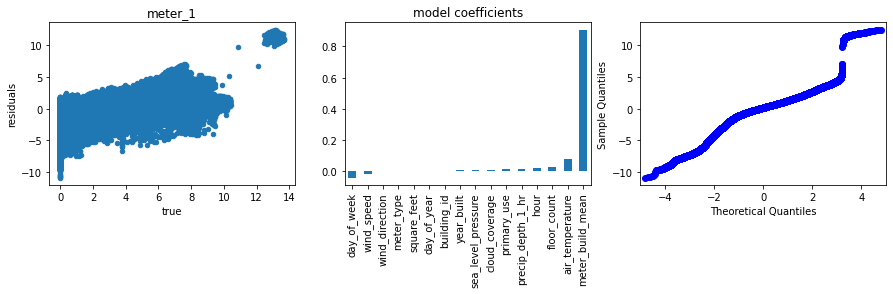

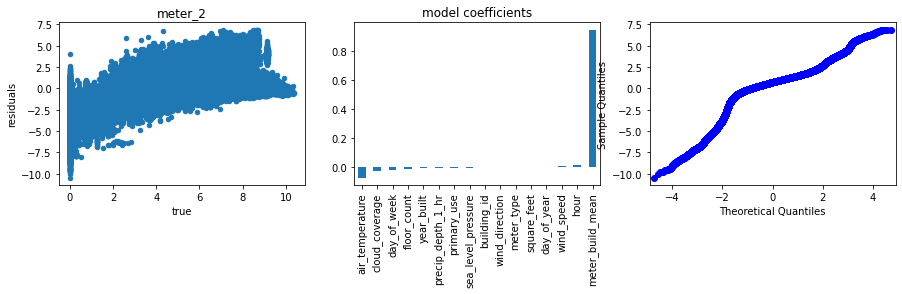

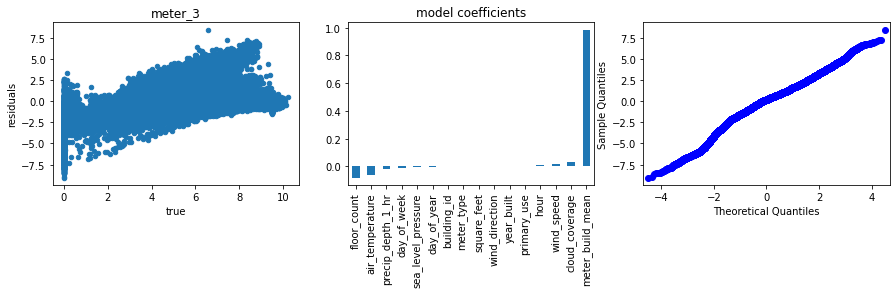

In [30]:
%%time
from sklearn.pipeline import Pipeline
drop_cols = correlated_cols
for target_meter in range(4):
  X_train,y_train = create_X_y(merged_train_df,target_meter,drop_cols)
  X_test,y_test = create_X_y(merged_test_df,target_meter,drop_cols)
  model_lr = Pipeline([('model',LinearRegression())])
  model_lr.fit(X_train,y_train)
  
  model_predict(model_lr,'Linear Regression',X_train,y_train,X_test,y_test)
  

The graphs above show that the residual plots show hetroscedacity (changing variance in residuals)
To remove hetroscedacity is it suggested to weighted least squares(But this would mean to assign individual weights to all records)

The q-q plot shows that the errors are not normally distributed , which means we need to try non-linear transformation

## We will standardize the data as that is what linear regression prefers.

In [31]:
from sklearn.pipeline import make_pipeline

CPU times: user 19 s, sys: 6.27 s, total: 25.2 s
Wall time: 15.8 s


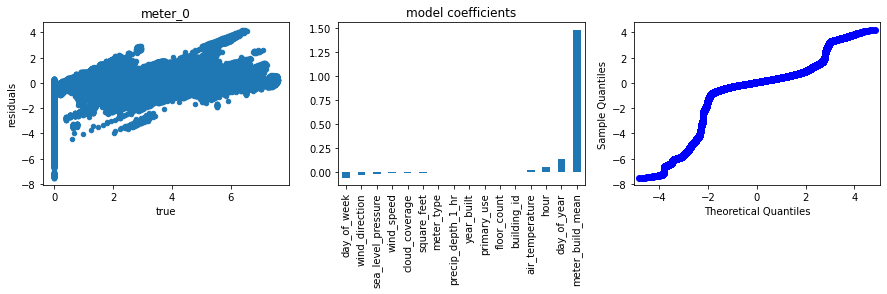

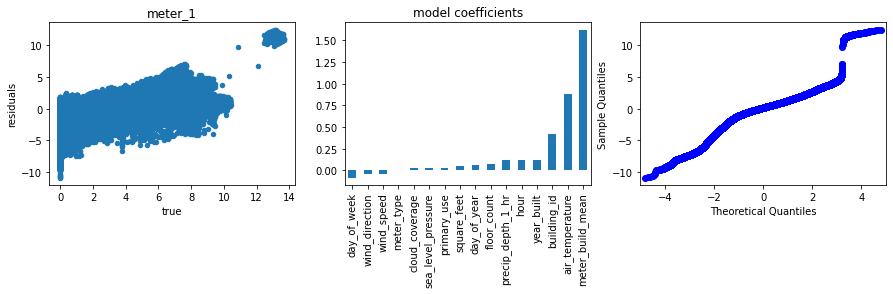

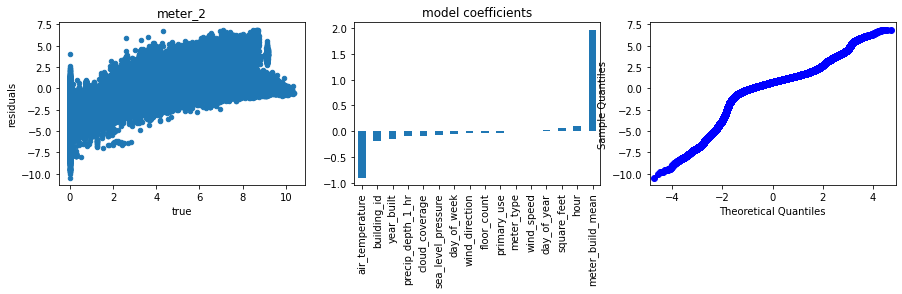

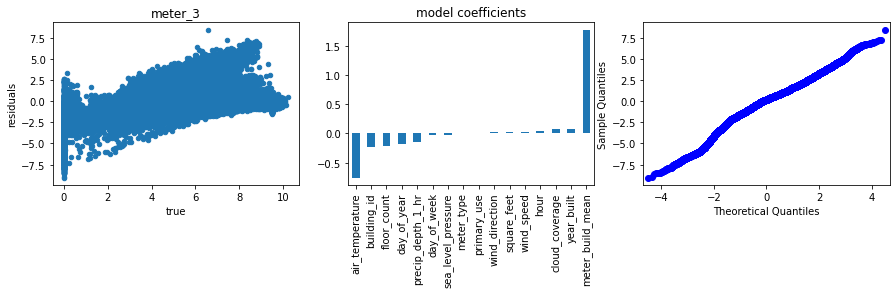

In [32]:
%%time
from sklearn.pipeline import make_pipeline
drop_cols = correlated_cols
for target_meter in range(4):
  X_train,y_train = create_X_y(merged_train_df,target_meter,drop_cols)
  X_test,y_test = create_X_y(merged_test_df,target_meter,drop_cols)
  model_ss_lr = Pipeline([('scaler',StandardScaler()),('model',LinearRegression())])
  model_ss_lr.fit(X_train,y_train)
  model_predict(model_ss_lr,'Linear regression with Standard Scaler',X_train,y_train,X_test,y_test)
  


## Ridge regression

CPU times: user 13 s, sys: 4.17 s, total: 17.2 s
Wall time: 12 s


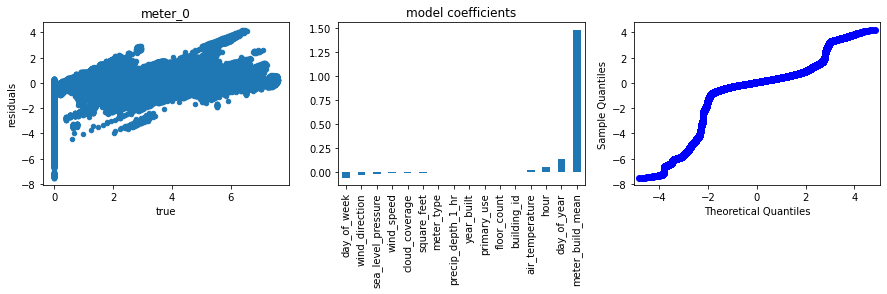

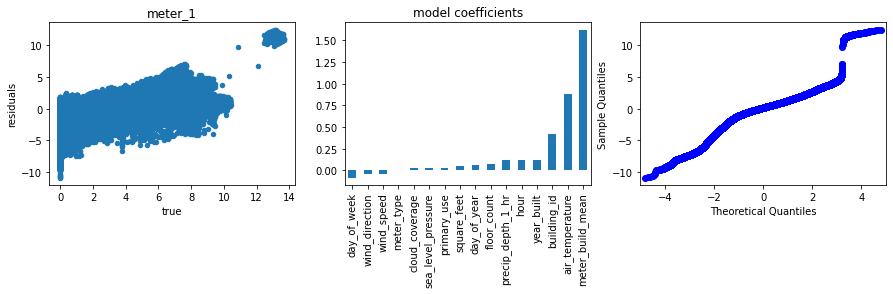

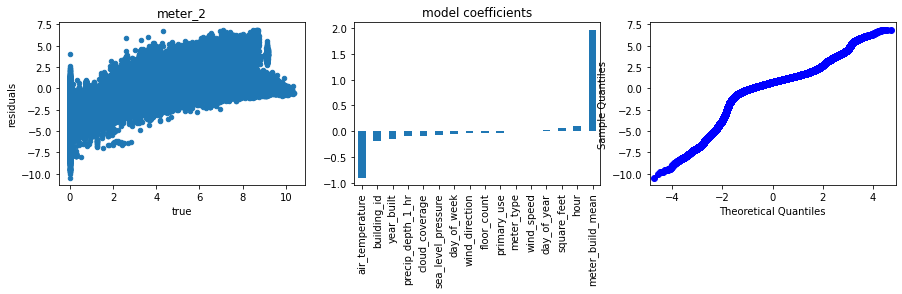

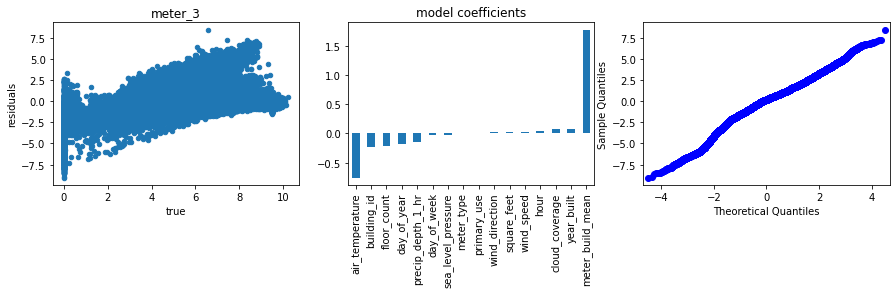

In [33]:
%%time
from sklearn import linear_model
from sklearn.pipeline import Pipeline
drop_cols = correlated_cols
for target_meter in range(4):
  X_train,y_train = create_X_y(merged_train_df,target_meter,drop_cols)
  X_test,y_test = create_X_y(merged_test_df,target_meter,drop_cols)
  #lr_ridge = linear_model.RidgeCV(alphas=np.logspace(-6, 6, 13))
  lr_ridge = Pipeline([('scaler',StandardScaler()),('model',linear_model.Ridge(alpha=.5))])
  lr_ridge.fit(X_train,y_train)
  model_predict(lr_ridge,'Linear regression with Ridge',X_train,y_train,X_test,y_test)

# SGD analysis

CPU times: user 58.4 s, sys: 2.43 s, total: 1min
Wall time: 58.1 s


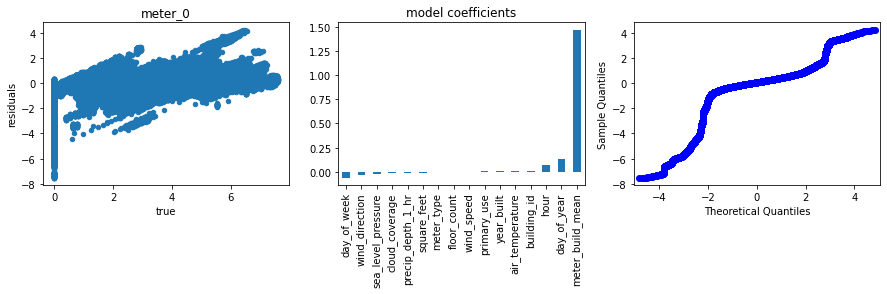

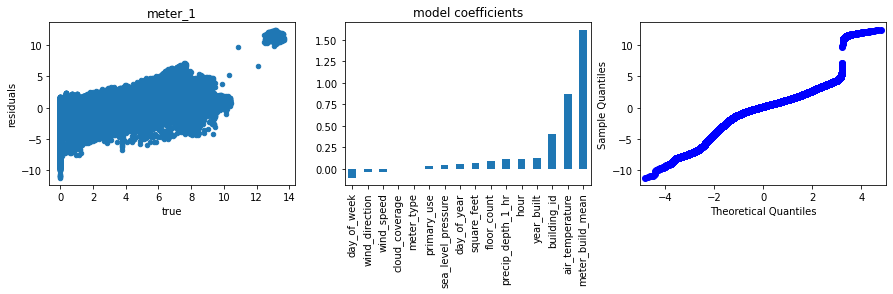

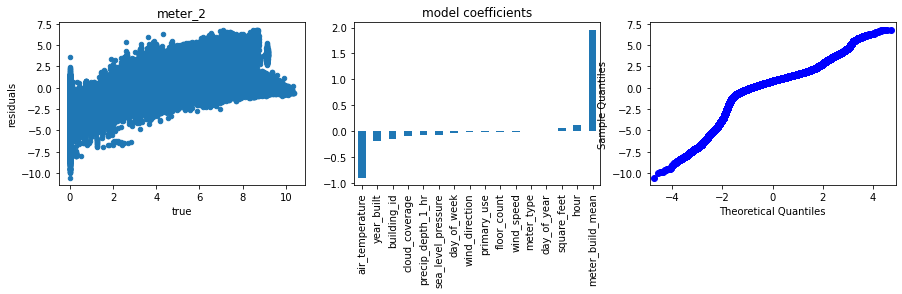

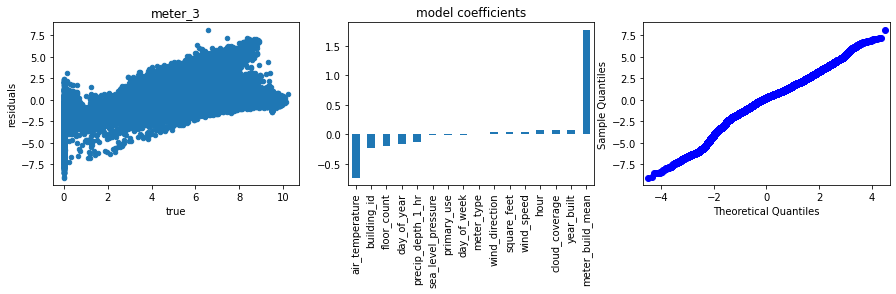

In [34]:
%%time
from sklearn.linear_model import SGDRegressor

drop_cols = correlated_cols
for target_meter in range(4):
  X_train,y_train = create_X_y(merged_train_df,target_meter,drop_cols)
  X_test,y_test = create_X_y(merged_test_df,target_meter,drop_cols)
  sgd_model = Pipeline([('scaler',StandardScaler()),('model',SGDRegressor())])
  sgd_model.fit(X_train,y_train)
  model_predict(sgd_model,'SGD with standard scaler',X_train,y_train,X_test,y_test)

# LGBM model analysis

In [35]:
from sklearn.ensemble import RandomForestRegressor

In [ ]:
'''
%%time
from sklearn.ensemble import RandomForestRegressor
for target_meter in range(4):
  X_train,y_train = create_X_y(merged_train_df,target_meter,correlated_cols)
  X_test,y_test = create_X_y(merged_test_df,target_meter,correlated_cols)
  #param_grid = {'n_estimators':np.arange(10,100)}
  rfc = Pipeline([('model',RandomForestRegressor(n_estimators=10))])
  #rfc_cv= GridSearchCV(rfc,param_grid,cv=5)
  rfc.fit(X_train,y_train)
  model_predict(rfc,'RFC',X_train,y_train,X_test,y_test,False)
'''

In [ ]:
'''
%%time
from sklearn.ensemble import RandomForestRegressor
target_meter = 0
X_train,y_train = create_X_y(merged_train_df,target_meter,correlated_cols)
X_test,y_test = create_X_y(merged_test_df,target_meter,correlated_cols)
#param_grid = {'n_estimators':np.arange(10,100)}
rfc_ss = Pipeline([('scaler',StandardScaler()),('model',RandomForestRegressor(n_estimators=10))])
#rfc_cv= GridSearchCV(rfc,param_grid,cv=5)
rfc.fit(X_train,y_train)

model_predict(rfc,'RFC',X_train,y_train,X_test,y_test,False)
'''

### Define model

In [39]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV

/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['building_id', 'day_of_week', 'day_of_year', 'hour', 'meter_type', 'month', 'primary_use', 'site_id', 'week']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['building_id', 'day_of_week', 'day_of_year', 'hour', 'meter_type', 'month', 'primary_use', 'site_id', 'week']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))
/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['building_id', 'day_of_week', 'day_of_year', 'hour', 'meter_type', 'month', 'primary_use', 'site_id', 'week']
  'New categorical_feature is {}'.format(sorted(list(categorical_f

CPU times: user 13min 43s, sys: 4.51 s, total: 13min 48s
Wall time: 3min 42s


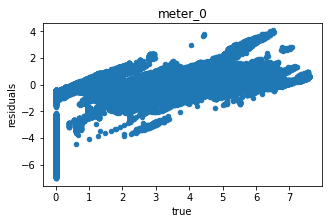

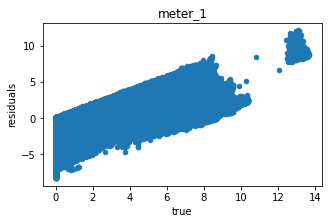

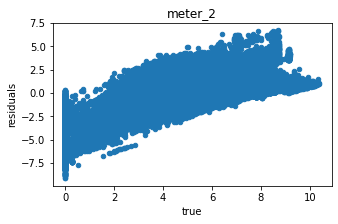

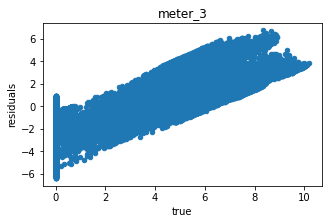

In [40]:
%%time
for target_meter in range(4):
  X_train,y_train = create_X_y(merged_train_df,target_meter)
  X_test,y_test = create_X_y(merged_test_df,target_meter)

  gbm = LGBMRegressor()
  model_lgb = gbm.fit(X_train,y_train,categorical_feature=category_cols)
  model_predict(model_lgb,'LGBM',X_train,y_train,X_test,y_test,False)

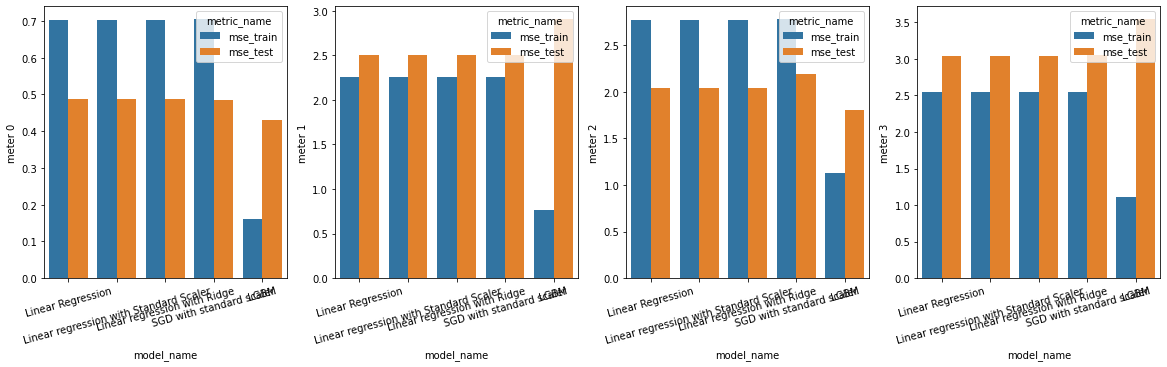

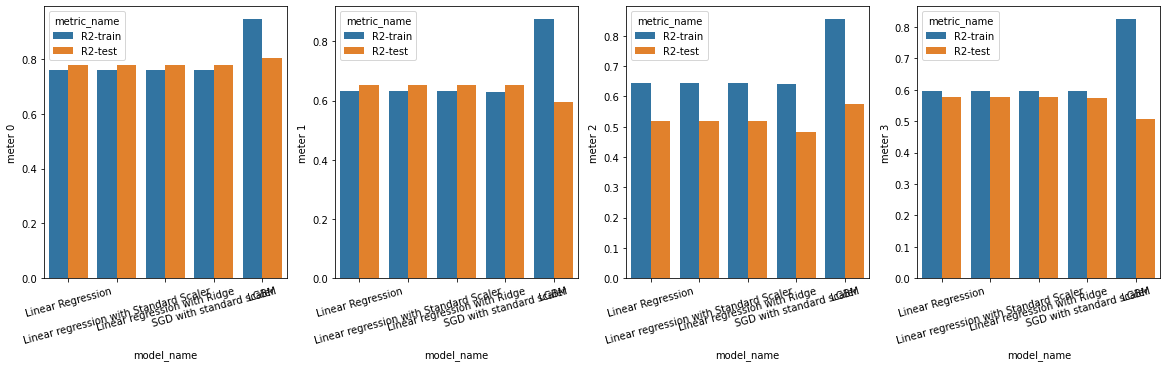

In [144]:
fig,axes = plt.subplots(1,4,figsize=(20,5))
for i in range(4): 
  axs = axes.ravel()[i]
  sns.barplot(x='model_name',y='metric_value',hue='metric_name',\
            data=model_compare_df[model_compare_df.meter_type==i].melt(id_vars=['model_name'],\
            value_vars=['mse_train', 'mse_test'],\
            var_name='metric_name',value_name = 'metric_value'),ax=axs)
  axs.set_xticklabels(labels = model_compare_df.model_name.unique(),rotation=15)
  axs.set_ylabel('meter ' + str(i))

fig,axes = plt.subplots(1,4,figsize=(20,5))
for i in range(4): 
  axs = axes.ravel()[i]
  sns.barplot(x='model_name',y='metric_value',hue='metric_name',\
            data=model_compare_df[model_compare_df.meter_type==i].melt(id_vars=['model_name'],\
            value_vars=['R2-train','R2-test'],\
            var_name='metric_name',value_name = 'metric_value'),ax=axs)
  axs.set_xticklabels(labels = model_compare_df.model_name.unique(),rotation=15)
  axs.set_ylabel('meter ' + str(i))
  

In [117]:
#LGBM seems to be performing best when it comes to R2-train metric and also has the least mse_train.
#However when it comes to the test metrics it performing worse in case of some meter_ids when compared to other alogorithms.

In [145]:
%%time
target_meter = 1
X_train,y_train = create_X_y(merged_train_df,target_meter)
X_test,y_test = create_X_y(merged_test_df,target_meter)

from sklearn.model_selection import GridSearchCV
param_dist = {"max_depth": [10,50],
              "learning_rate" : [0.05,0.1],
              "num_leaves": [31,150,300],
              "n_estimators": [10,100],
             }
#gbm.boosting = 'goss'
grid_search = GridSearchCV(gbm, param_grid=param_dist,cv = 5, scoring="neg_mean_squared_error", verbose=5)
grid_search.fit(X_train,y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=31 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=31, score=-2.469, total=   7.2s
[CV] learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=31 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    7.2s remaining:    0.0s


[CV]  learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=31, score=-3.826, total=   6.4s
[CV] learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=31 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   13.6s remaining:    0.0s


[CV]  learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=31, score=-2.891, total=   6.6s
[CV] learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=31 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   20.2s remaining:    0.0s


[CV]  learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=31, score=-4.883, total=   6.1s
[CV] learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=31 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   26.3s remaining:    0.0s


[CV]  learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=31, score=-4.471, total=   6.3s
[CV] learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=150 
[CV]  learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=150, score=-2.385, total=   7.4s
[CV] learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=150 
[CV]  learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=150, score=-3.760, total=   7.5s
[CV] learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=150 
[CV]  learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=150, score=-2.828, total=   7.4s
[CV] learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=150 
[CV]  learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=150, score=-4.726, total=   7.0s
[CV] learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=150 
[CV]  learning_rate=0.05, max_depth=10, n_estimators=10, num_leaves=150, score=-4.295, total=   7.5s
[CV] learning_rate=0.05, max_depth=

[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed: 46.4min finished


CPU times: user 3h 28s, sys: 21 s, total: 3h 49s
Wall time: 46min 58s


In [146]:
grid_search.best_estimator_

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=10,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [148]:
grid_search.best_score_

-1.7579683859957569

In [149]:
grid_search.best_params_

{'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 100, 'num_leaves': 31}

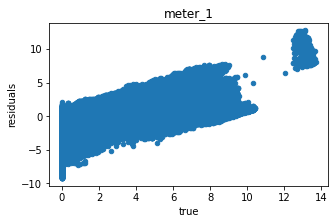

In [151]:
model_predict(grid_search,'LGBM_gridsearchCV',X_train,y_train,X_test,y_test,False)

In [154]:
model_compare_df

,model_name,meter_type,mse_train,mse_test,R2-train,R2-test
0,Linear Regression,0,0.703912,0.488190,0.758801,0.778717
1,Linear Regression,1,2.256075,2.504188,0.631126,0.651957
2,Linear Regression,2,2.774143,2.041620,0.642776,0.517962
3,Linear Regression,3,2.550813,3.036178,0.595687,0.576152
4,Linear regression with Standard Scaler,0,0.703912,0.488190,0.758801,0.778717
5,Linear regression with Standard Scaler,1,2.256075,2.504188,0.631126,0.651957
6,Linear regression with Standard Scaler,2,2.774143,2.041620,0.642776,0.517962
7,Linear regression with Standard Scaler,3,2.550813,3.036178,0.595687,0.576152
8,Linear regression with Ridge,0,0.703912,0.488190,0.758801,0.778717
9,Linear regression with Ridge,1,2.256075,2.504188,0.631126,0.651957


In [ ]:
#After using GridSearchCV with LGBM we see an improvement in the test dataset scores.